## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [65]:
# Put your imports here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import time

from matplotlib import rcParams

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
data_folder = './data/'
task_1_folder = data_folder + 'Task_1/'
task_2_folder = data_folder + 'Task_2/'

## Task 1: Boosting the economy by incentivizing self-employment

Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.

Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.

**A)** You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,220 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

__A) You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,220 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?__

In [3]:
#Load data
county_data = pd.read_csv(task_1_folder + 'acs2015_county_data.csv')
county_data.head(5)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [4]:
county_data.columns

Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

In [5]:
#First, get only relevant columns for the task 1
employment_data = county_data[['CensusId', 'State', 'County', 'Citizen', 'IncomeErr', 'IncomePerCap',
                                         'IncomePerCapErr', 'SelfEmployed']]

employment_data.head(5)

,CensusId,State,County,Citizen,IncomeErr,IncomePerCap,IncomePerCapErr,SelfEmployed
0,1001,Alabama,Autauga,40725,2391.0,24974,1080,5.5
1,1003,Alabama,Baldwin,147695,1263.0,27317,711,5.8
2,1005,Alabama,Barbour,20714,2973.0,16824,798,7.3
3,1007,Alabama,Bibb,17495,3995.0,18431,1618,6.7
4,1009,Alabama,Blount,42345,3141.0,20532,708,4.2


In [6]:
#Get the columns that interest us for part A
counties_employment = employment_data[['CensusId','IncomePerCap', 'SelfEmployed']].set_index(['CensusId'])
counties_employment.describe()

,IncomePerCap,SelfEmployed
count,3220.000000,3220.000000
mean,23981.771739,7.931801
std,6204.339960,3.914974
min,5878.000000,0.000000
25%,20238.500000,5.400000
50%,23460.000000,6.900000
75%,27053.250000,9.400000
max,65600.000000,36.600000


First, we will try a scatter plot to see if there is a visible correlation.

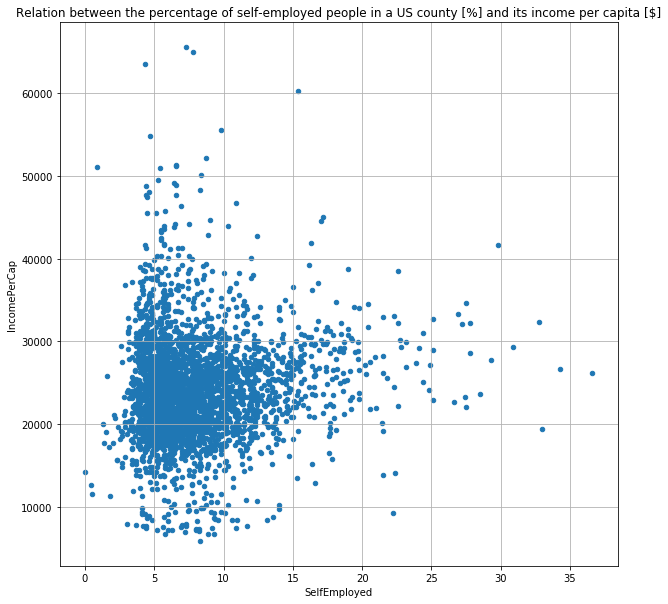

In [7]:
counties_employment.plot(kind='scatter',
             x='SelfEmployed', y='IncomePerCap', figsize=(10, 10), grid=True,
            title='Relation between the percentage of self-employed people in a US county [%] and its income per capita [$]')

This is a bit of a mess, but on the bright side, there aren't too many outliers (median is close to mean), so we can probably trust Pearson (which is vulnerable around outliers).

In [8]:
counties_employment.corr('pearson')

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.087274
SelfEmployed,0.087274,1.000000


Testing Pearson coefficients, we see values very close to 0, that is, no distribution.

__B) The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.__

In [9]:
#Get the data we want
wisconsin_data = county_data[county_data['State'] == 'Wisconsin'][['CensusId', 'County', 'IncomePerCap', 'SelfEmployed']]\
                        .set_index('CensusId')

tennessee_data = county_data[county_data['State'] == 'Tennessee'][['CensusId', 'County', 'IncomePerCap', 'SelfEmployed']]\
                        .set_index('CensusId')

minnesota_data = county_data[county_data['State'] == 'Minnesota'][['CensusId', 'County', 'IncomePerCap', 'SelfEmployed']]\
                        .set_index('CensusId')

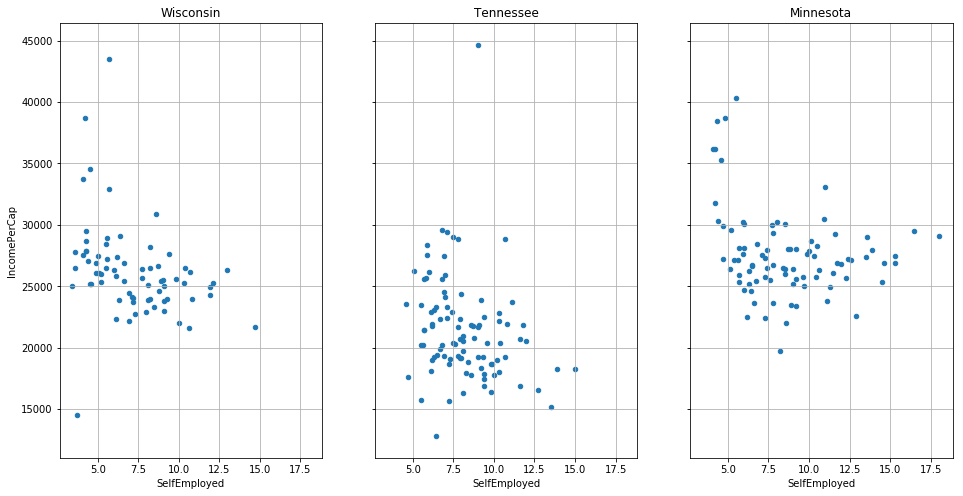

In [10]:
#For starters, plot it:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
wisconsin_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[0], figsize=(16, 8), 
                    title='Wisconsin', grid=True)
tennessee_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[1], grid=True, title='Tennessee')
minnesota_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[2], grid=True, title='Minnesota')

In [11]:
wisconsin_data.corr('pearson')


,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.329053
SelfEmployed,-0.329053,1.000000


In [12]:
tennessee_data.corr('pearson')

,IncomePerCap,SelfEmployed
IncomePerCap,1.00000,-0.23836
SelfEmployed,-0.23836,1.00000


In [13]:
minnesota_data.corr('pearson')

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,-0.253855
SelfEmployed,-0.253855,1.000000


__C) In which state within set A is the observed effect of self-employment on per-capita income the strongest?__

__D) Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.__

In [14]:
#Get the data we want
jersey_data = county_data[county_data['State'] == 'New Jersey'][['CensusId', 'County', 'IncomePerCap', 'SelfEmployed']]\
                        .set_index('CensusId')

kansas_data = county_data[county_data['State'] == 'Kansas'][['CensusId', 'County', 'IncomePerCap', 'SelfEmployed']]\
                        .set_index('CensusId')

rhode_data = county_data[county_data['State'] == 'Rhode Island'][['CensusId', 'County', 'IncomePerCap', 'SelfEmployed']]\
                        .set_index('CensusId')

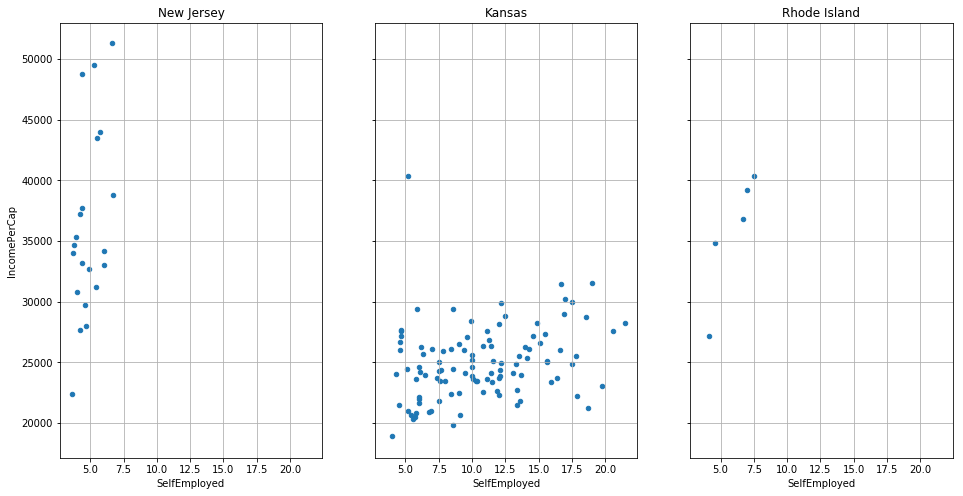

In [15]:
#For starters, plot it:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
jersey_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[0], figsize=(16, 8), 
                    title='New Jersey', grid=True)
kansas_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[1], grid=True, title='Kansas')
rhode_data.plot(kind='scatter', x='SelfEmployed', y='IncomePerCap', ax=axs[2], grid=True, title='Rhode Island')

In [16]:
jersey_data.corr('pearson')

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.480448
SelfEmployed,0.480448,1.000000


In [17]:
kansas_data.corr('pearson')

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.258103
SelfEmployed,0.258103,1.000000


In [18]:
rhode_data.corr('pearson')

,IncomePerCap,SelfEmployed
IncomePerCap,1.000000,0.902179
SelfEmployed,0.902179,1.000000


## Task 2: All you need is love… And a dog!

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

**A)** Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.

**B)** Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

**C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

You are allowed to use the scikit-learn library to implement your classifiers.

__A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1.__

In [19]:
#Load the data
shelter_data = pd.read_csv(task_2_folder + 'aac_intakes_outcomes.csv')[['animal_type', 'intake_year', 'intake_condition', 
                                                                        'intake_number', 'intake_type', 'sex_upon_intake',
                                                                        'age_upon_intake_(years)', 'time_in_shelter_days',
                                                                        'sex_upon_outcome', 'age_upon_outcome_(years)',
                                                                        'outcome_type']]
shelter_data.head(5)

,animal_type,intake_year,intake_condition,intake_number,intake_type,sex_upon_intake,age_upon_intake_(years),time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(years),outcome_type
0,Dog,2017,Normal,1.0,Stray,Neutered Male,10.0,0.588194,Neutered Male,10.0,Return to Owner
1,Dog,2014,Normal,2.0,Public Assist,Neutered Male,7.0,1.259722,Neutered Male,7.0,Return to Owner
2,Dog,2014,Normal,3.0,Public Assist,Neutered Male,6.0,1.113889,Neutered Male,6.0,Return to Owner
3,Dog,2014,Normal,1.0,Owner Surrender,Neutered Male,10.0,4.970139,Neutered Male,10.0,Transfer
4,Dog,2013,Injured,1.0,Public Assist,Neutered Male,16.0,0.119444,Neutered Male,16.0,Return to Owner


In [20]:
#get features and labels
X_categorical = shelter_data.drop(['outcome_type'], axis=1)
y_categorical = shelter_data[['outcome_type']]

In [21]:
#Convert categorical variables to dummy variables (indicator variables)
X = pd.get_dummies(X_categorical)
y = pd.get_dummies(y_categorical)[['outcome_type_Adoption']]
X.head(5)

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,2017,1.0,10.0,0.588194,10.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2014,2.0,7.0,1.259722,7.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2014,3.0,6.0,1.113889,6.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2014,1.0,10.0,4.970139,10.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2013,1.0,16.0,0.119444,16.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [22]:
y.head(5)

,outcome_type_Adoption
0,0
1,0
2,0
3,0
4,0


In [23]:
#Split the data into training and test sets

def split_data(X, y, prop_test):
    
    total_size = len(y)
    test_size = int(total_size * prop_test)
    
    #get a random set of indices for the test set
    test_indices = np.random.randint(low=0, high=total_size, size=(test_size,))
    
    #take these indices for the test
    test_X = X.loc[test_indices].reset_index(drop=True)
    test_y = y.loc[test_indices].reset_index(drop=True)

    #drop these indices from training
    train_X = X.drop(X.index[test_indices]).reset_index(drop=True)
    train_y = y.drop(y.index[test_indices]).reset_index(drop=True)
    
    return train_X, train_y, test_X, test_y

In [24]:
#Generation of training and testing datasets
train_X, train_y, test_X, test_y = split_data(X, y['outcome_type_Adoption'], 0.2)

In [25]:
#Standardize the values of each feature in the data to have mean 0 and variance 1
train_X.describe()

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
count,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,...,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000,65206.000000
mean,2015.435297,1.127642,2.106490,16.784684,2.141606,0.004493,0.369797,0.570484,0.055225,0.003911,...,0.297733,0.317670,0.159234,0.139926,0.085422,0.117090,0.121492,0.355412,0.320569,0.085422
std,1.302311,0.459020,2.888740,41.829759,2.895813,0.066883,0.482753,0.495011,0.228421,0.062414,...,0.457265,0.465574,0.365897,0.346913,0.279510,0.321531,0.326701,0.478642,0.466699,0.279510
min,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,1.000000,0.164384,1.100000,0.246575,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,1.000000,1.000000,4.978125,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,1.000000,3.000000,13.543403,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,2018.000000,13.000000,25.000000,1606.194444,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Standarization formula: 

    for each index i in the set

    x_i = (x_i - x.mean)/x.std

In [26]:
train_X_std = (train_X - train_X.mean())/train_X.std()
test_X_std = (test_X - test_X.mean())/test_X.std()
train_X_std.describe()

#note that the std is 1 as wanted and the mean is so small, it tends towards 0

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
count,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,...,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04,6.520600e+04
mean,-4.590014e-14,5.182821e-14,1.782171e-13,2.280450e-15,2.551976e-13,5.415374e-15,1.864870e-15,-2.073218e-14,-1.559434e-14,-3.475346e-15,...,-4.123047e-15,4.087363e-14,4.136132e-14,-3.884177e-15,-2.746074e-14,-1.165949e-15,-1.762305e-14,-4.811863e-15,-2.910274e-15,-2.746074e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.869982e+00,-2.780744e-01,-7.292073e-01,-4.012618e-01,-7.395526e-01,-6.718381e-02,-7.660169e-01,-1.152468e+00,-2.417688e-01,-6.265761e-02,...,-6.511175e-01,-6.823194e-01,-4.351878e-01,-4.033458e-01,-3.056117e-01,-3.641659e-01,-3.718754e-01,-7.425431e-01,-6.868856e-01,-3.056117e-01
25%,-1.102116e+00,-2.780744e-01,-6.723023e-01,-3.749647e-01,-6.544036e-01,-6.718381e-02,-7.660169e-01,-1.152468e+00,-2.417688e-01,-6.265761e-02,...,-6.511175e-01,-6.823194e-01,-4.351878e-01,-4.033458e-01,-3.056117e-01,-3.641659e-01,-3.718754e-01,-7.425431e-01,-6.868856e-01,-3.056117e-01
50%,-3.342500e-01,-2.780744e-01,-3.830356e-01,-2.822526e-01,-3.942264e-01,-6.718381e-02,-7.660169e-01,8.676895e-01,-2.417688e-01,-6.265761e-02,...,-6.511175e-01,-6.823194e-01,-4.351878e-01,-4.033458e-01,-3.056117e-01,-3.641659e-01,-3.718754e-01,-7.425431e-01,-6.868856e-01,-3.056117e-01
75%,1.201482e+00,-2.780744e-01,3.093076e-01,-7.748745e-02,2.964259e-01,-6.718381e-02,1.305434e+00,8.676895e-01,-2.417688e-01,-6.265761e-02,...,1.535798e+00,1.465567e+00,-4.351878e-01,-4.033458e-01,-3.056117e-01,-3.641659e-01,-3.718754e-01,1.346702e+00,1.455824e+00,-3.056117e-01
max,1.969348e+00,2.586459e+01,7.925084e+00,3.799710e+01,7.893601e+00,1.488431e+01,1.305434e+00,8.676895e-01,4.136120e+00,1.595951e+01,...,1.535798e+00,1.465567e+00,2.297823e+00,2.479224e+00,3.272076e+00,2.745959e+00,2.689032e+00,1.346702e+00,1.455824e+00,3.272076e+00


__B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.__

In [27]:
#train the classifier on the training sets
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(train_X_std, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
# function to threshold the outcome probabilities
def threshold(prediction, thresh):
    if prediction < thresh:
        return 0
    return 1

In [29]:
#predict with 0.5 threshold
prediction_probs = pd.DataFrame(logistic.predict_proba(test_X_std))
pred_thresh_50 = prediction_probs[1].map(lambda r: threshold(r, 0.5))

__Confusion matrix:__

                               Predicted
                          1        |         0
                  ------------------------------------
                1 | said 1, was 1  | said 0, was 1
                  |   (true pos)   |  (false neg)
        Actual    | ----------------------------------
                0 | said 1, was 0  | said 0, was 0
                  |   (false pos)  |  (true neg)



In [30]:
#functions to create and parse the confusion matrix
def confusion_matrix(test_y, pred):
    nb_values = len(test_y)
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(nb_values):
        if test_y[i] == 1:
            if pred[i] == 1:
                tp += 1
            else:
                fn += 1
        else:
            if pred[i] == 1:
                fp += 1
            else:
                tn += 1
                
    return np.array([[tp, fn], [fp, tn]])


def parse_confusion_matrix(confusion_matrix):
    tp = confusion_matrix[0][0]
    tn = confusion_matrix[1][1]
    fp = confusion_matrix[1][0]
    fn = confusion_matrix[0][1]
    return tp, tn, fp, fn

Confusion matrix values: 
 [[5461 1219]
 [1652 7602]] 



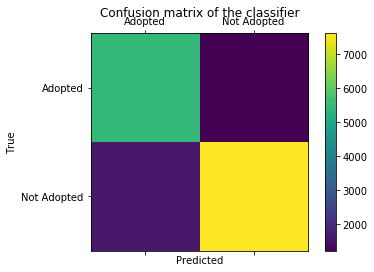

In [31]:
#Generate values for confusion matrix
conf_matrix = confusion_matrix(test_y, pred_thresh_50)
print('Confusion matrix values: \n', conf_matrix, '\n')

#plot confusion matrix with a colorscale representation
labels = ['Adopted', 'Not Adopted']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)

plt.title('Confusion matrix of the classifier')

fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

plt.xlabel('Predicted')
plt.ylabel('Real value')
plt.show()

__Formulas__:

_Accuracy: ratio of correctly predicted observation to the total observations. Great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same._

     accuracy = (True pos +True neg) / (True pos + False pos + False neg + True neg) 
     
_Precision: ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate._

     precision = True pos/(True pos + False pos)
     
_Recall: ratio of correctly predicted positive observations to the all observations in actual class - yes_
     
     recall = True Pos/(True Pos + False Neg)
     
_F1 Score: weighted average of Precision and Recall. Takes both false positives and false negatives into account. Usually more useful than accuracy, especially if you have an uneven class distribution. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall._
     
     F1-score =  2*(Recall * Precision) / (Recall + Precision)
     
(Source: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)

In [32]:
#functions to evaluate the model:
#...  Note that for divisions, if the bottom is 0, then the top is also 0,
#...  (the strictly positive top is included in the bottom sum),
#...  so we have 0/0 ~ 1

#Calculate the accurace
def get_accuracy(confusion_matrix):
    tp, tn, fp, fn = parse_confusion_matrix(confusion_matrix)
    return (tp + tn)/(tp + tn + fp + fn)

#Calculate the precision
def get_precision(confusion_matrix, positive):
    tp, tn, fp, fn = parse_confusion_matrix(confusion_matrix)
    
    if positive:
        all_pos = (tp + fp)
        if all_pos == 0:
            return 1
        return tp/all_pos
    
    all_neg = (tn + fn)
    if all_neg == 0:
        return 1
    return tn/all_neg

#Calculate the recall
def get_recall(confusion_matrix, positive):
    tp, tn, fp, fn = parse_confusion_matrix(confusion_matrix)
    
    if positive:
        pos = (tp + fn)
        if pos == 0:
            return 1
        return tp/pos
    
    neg = tn + fp
    if neg == 0:
        return 1
    return tn/neg

#Calculate the F1 score
def get_f1(recall, precision):
    if recall + precision == 0:
        return 1
    return (2 * recall * precision)/(recall + precision)

#Get overall performance evaluation
def get_performance_eval(confusion_matrix, thresh, print_info, hide = False):
        
    accuracy = get_accuracy(confusion_matrix)
    
    pos_precision = get_precision(confusion_matrix, True)
    pos_recall = get_recall(confusion_matrix, True)
    pos_f1 = get_f1(pos_recall, pos_precision)
    
    neg_precision = get_precision(confusion_matrix, False)
    neg_recall = get_recall(confusion_matrix, False)
    neg_f1 = get_f1(neg_recall, neg_precision)
    
    if print_info == True:
        print('Stats--------------------------------------------------')
        print(' ')
        print('Threshold: ', thresh)
        print(' ')
        print('Matrix: ')
        print(confusion_matrix)
        print('')
        print('Accuracy:  ', accuracy)
        print(' ')
        print('              Positive         / Negative')
        print('Precision: ', pos_precision, "/", neg_precision)
        print('Recall:    ', pos_recall, '/', neg_recall)
        print('F1-Score:  ', pos_f1, '/', neg_f1)
        print('-------------------------------------------------------')
        
    if hide == False :    
        return [thresh, accuracy, pos_precision, neg_precision, pos_recall, neg_recall, pos_f1, neg_f1]

In [33]:
get_performance_eval(conf_matrix, 0.5, True, True)

Stats--------------------------------------------------
 
Threshold:  0.5
 
Matrix: 
[[5461 1219]
 [1652 7602]]

Accuracy:   0.8198192544245011
 
              Positive         / Negative
Precision:  0.7677491916209757 / 0.8618070513547217
Recall:     0.8175149700598803 / 0.8214826021180031
F1-Score:   0.7918509388820417 / 0.8411618257261412
-------------------------------------------------------


In [34]:
#Try a range of thresholds between 0 and 1 (by steps of 0.05)
stats = []
for thresh in np.arange(0.0, 1.05, 0.05):
    #try each threshold on the probs
    pred = prediction_probs[1].map(lambda r: threshold(r, thresh))
    
    #and evaluate the model
    matrix = confusion_matrix(test_y, pred)
    stat = get_performance_eval(matrix, thresh, False)
    
    #add it to the list for comparison
    stats.append(stat)

stats_df = pd.DataFrame(stats,
                        columns=['Threshold', 'Accuracy','+Precision', '-Precision', '+Recall', '-Recall', '+F1', '-F1'])
stats_df

,Threshold,Accuracy,+Precision,-Precision,+Recall,-Recall,+F1,-F1
0,0.00,0.419229,0.419229,1.000000,1.000000,0.000000,0.590784,0.000000
1,0.05,0.580269,0.499699,0.983057,0.993263,0.282148,0.664896,0.438455
2,0.10,0.717773,0.601130,0.962653,0.971257,0.534796,0.742631,0.687600
3,0.15,0.744320,0.627570,0.952797,0.959581,0.588935,0.758849,0.727928
4,0.20,0.762207,0.647545,0.945250,0.949701,0.626864,0.770043,0.753817
5,0.25,0.775009,0.664750,0.933344,0.934731,0.659715,0.776955,0.773029
6,0.30,0.792205,0.689376,0.922148,0.917964,0.701426,0.787416,0.796784
7,0.35,0.805385,0.713978,0.906353,0.893862,0.741517,0.793858,0.815691
8,0.40,0.817497,0.740500,0.892116,0.869311,0.780095,0.799752,0.832353
9,0.45,0.821200,0.757633,0.876809,0.843263,0.805273,0.798158,0.839520


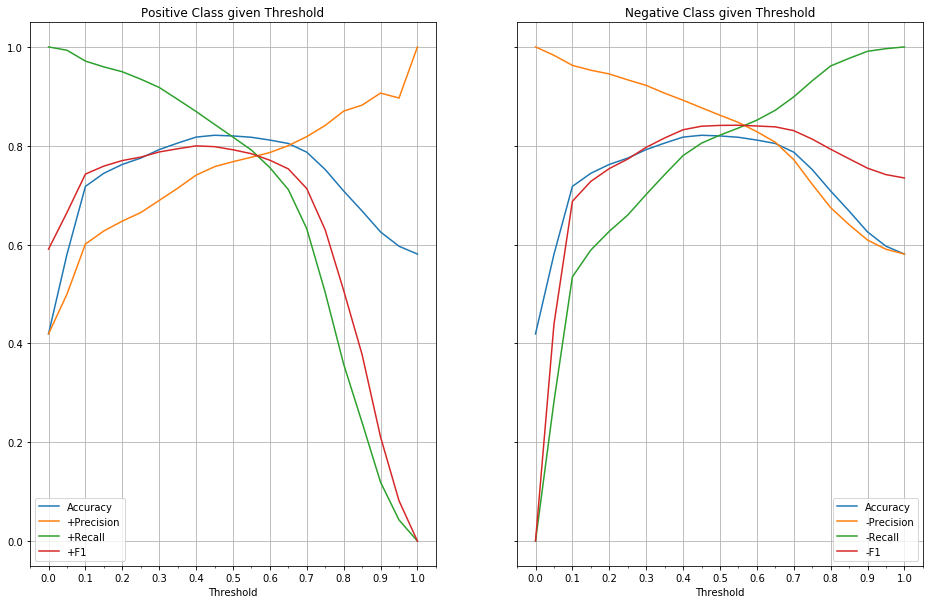

In [35]:
#plot the data
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[1].xaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(0.05))

stats_df.plot(kind='line', x='Threshold', y=['Accuracy', '+Precision', '+Recall', '+F1'], 
              ax=axs[0], grid=True, title='Positive Class given Threshold', figsize=(16, 10))
stats_df.plot(kind='line', x='Threshold', y=['Accuracy', '-Precision', '-Recall', '-F1'], 
              ax=axs[1], grid=True, title='Negative Class given Threshold')

We will use the negative class, because it has both higher precision and recall. 

We want to absolutely minimize false negatives (killing animals that actually might have gotten adopted), so we want to __maximize precision__ (which is inversely proportionate to the number of false negatives). But of course this alone is not enough (because precision can be maximized by setting all negatives to 0 and refusing to kill any animal, which is not possible), so we also __take into account recall__, to make sure we aren't keeping animals that won't ever be adopted. These two values intersect at their mutually maximal point with __threshold=0.56__.

In [36]:
#Evaluation of prediction with threshold=0.56

pred = prediction_probs[1].map(lambda r: threshold(r, 0.56))
matrix = confusion_matrix(test_y, pred)
get_performance_eval(matrix, 0.56, True, True)

Stats--------------------------------------------------
 
Threshold:  0.56
 
Matrix: 
[[5233 1447]
 [1494 7760]]

Accuracy:   0.8154261327977909
 
              Positive         / Negative
Precision:  0.7779099152668352 / 0.8428369718692299
Recall:     0.7833832335329342 / 0.8385562999783878
F1-Score:   0.7806369806817334 / 0.8406911868262825
-------------------------------------------------------


__C) Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.__

_Note that we chose accuracy as our evalution metric_

In [37]:
#Functions for feature selection

#function to select the feature without which accuracy is highest
def get_worst_feature(X_train, X_test, y_train, y_test, thresh):
    
    #prepare trainer
    logistic = LogisticRegression(solver='lbfgs')
    
    #prepare trackers
    features = X_train.columns
    worst_feat = features[0]
    worst_acc = 0.0
    
    #try training with each feature removed at a time, and drop the one resulting in the highest accuracy
    # (training is okay even without it)
    for feature in features:
        X_train_new = X_train.drop(feature, axis=1)
        X_test_new = X_test.drop(feature, axis=1)
        logistic.fit(X_train_new, y_train)
        prediction_probs = pd.DataFrame(logistic.predict_proba(X_test_new))
        pred = prediction_probs[1].map(lambda r: threshold(r, thresh))
        matrix = confusion_matrix(y_test, pred)
        accuracy = get_accuracy(matrix)
        
        if accuracy > worst_acc:
            worst_feat = feature
            worst_acc = accuracy
    
    return worst_feat

#Function to remove features until only the k best ones are left 
def reduce_features(X_train, X_test, y_train, y_test, k, thresh):

    while X_train.shape[1] > k:
        worst_feature = get_worst_feature(X_train, X_test, y_train, y_test, thresh)
        X_train.drop(worst_feature, axis=1, inplace=True)
        X_test.drop(worst_feature, axis=1, inplace=True)
    return X_train, X_test


In [38]:
#Functions for cross-validation

#get k indice arrays splitting the data evenly
def k_way_split_indices(X, y, k):
    
    total_size = len(y)
    sample_size = int(total_size * (1/k))
    
    #get the indices
    indices = X.index.tolist()
    
    #shuffle them for randomness
    np.random.shuffle(indices)
    
    #split the shuffled indices into even groups
    indice_arrays = []
    
    for sample_nb in range(k):
        indice_arrays.append(indices[sample_nb * sample_size: (sample_nb + 1) * sample_size])
    
    return indice_arrays

#do k-fold crossvalidation on a given classifier and return the average of the results 
def k_fold_cross_validate(X, y, k, thresh, classifier):
        
    #split the data into k groups
    indice_arrays = k_way_split_indices(X, y, k)
    
    stats = []
    
    #for each group of indices
    for i in range(k):
        
        indices = indice_arrays[i]
        
        #the indices mark the validation data
        test_X = X.loc[indices].reset_index(drop=True)
        test_y = y.loc[indices].reset_index(drop=True)

        #the rest is training data
        train_X = X.drop(X.index[indices]).reset_index(drop=True)
        train_y = y.drop(y.index[indices]).reset_index(drop=True)
        
        #train on the training data
        classifier.fit(train_X, train_y)
        
        #predict on the validation set
        prediction_probs = pd.DataFrame(classifier.predict_proba(test_X))
        pred_thresh = prediction_probs[1].map(lambda r: threshold(r, thresh))
        
        #save the model evaluation
        matrix = confusion_matrix(test_y, pred_thresh)
        stat = get_performance_eval(matrix, thresh, False)
        stats.append(stat)
        
    #average the model evaluations
    stats_average = [sum(stat)/k for stat in zip(*stats)]
    
    return stats_average

In [39]:
#Do cross validation on a set of models, each time with fewer features
def vary_features(X_train, X_test, y_train, y_test, thresh, ks, fold):
    
    #classifier
    logistic = LogisticRegression(solver='lbfgs')
    
    nb_datapoints = len(y_test)
    
    stats = []
    
    #for each number of features
    for k in ks:
        
        #remove features until size is k
        X_train, X_test = reduce_features(X_train, X_test, y_train, y_test, k, thresh)
        
        #get evaluation through cross validation
        stat_k = k_fold_cross_validate(X_train, y_train, fold, thresh, logistic)
        
        #save the size and features with the stats
        stat_k[0] = k
        stat_k.append(X_train.columns.tolist())
        stats.append(stat_k)
    
    return pd.DataFrame(stats
                , columns=['k', 'Accuracy','+Precision', '-Precision', '+Recall', '-Recall', '+F1', '-F1', 'Columns'])
        
    

In [40]:
thresh = 0.56
#we order these in descending order for the 
ks = [30, 25, 20, 15, 10, 5, 1]
feature_reduction = vary_features(train_X_std.copy(), test_X_std.copy(), train_y, test_y, thresh, ks, 5)

In [41]:
#show performance in function of number of features
feature_reduction

,k,Accuracy,+Precision,-Precision,+Recall,-Recall,+F1,-F1,Columns
0,30,0.818925,0.784064,0.844633,0.788271,0.841346,0.786142,0.842975,"[intake_year, intake_number, age_upon_intake_(..."
1,25,0.818710,0.783804,0.844447,0.788111,0.841089,0.785937,0.842756,"[intake_year, intake_number, age_upon_intake_(..."
2,20,0.818864,0.783405,0.845104,0.789202,0.840569,0.786266,0.842815,"[intake_year, intake_number, age_upon_intake_(..."
3,15,0.819140,0.784334,0.844831,0.788508,0.841514,0.786402,0.843161,"[intake_year, intake_number, age_upon_intake_(..."
4,10,0.818450,0.783706,0.844055,0.787384,0.841143,0.785534,0.842593,"[intake_year, age_upon_intake_(years), time_in..."
5,5,0.800184,0.750064,0.840334,0.790117,0.807580,0.769551,0.823621,"[age_upon_intake_(years), time_in_shelter_days..."
6,1,0.657036,0.623737,0.672740,0.473499,0.791198,0.538323,0.727170,[sex_upon_outcome_Spayed Female]


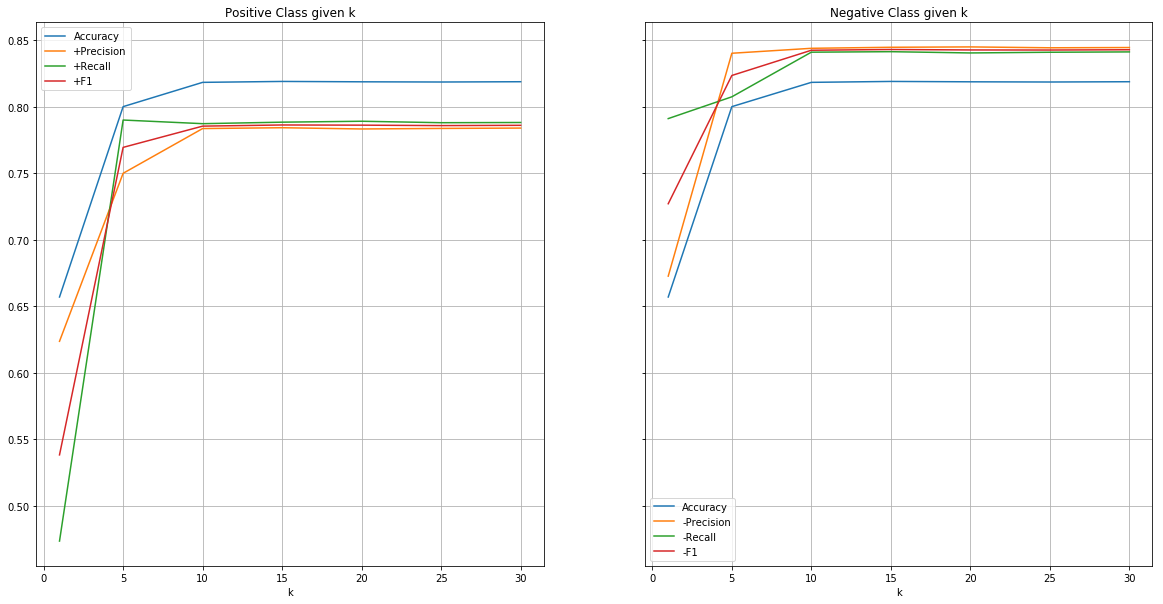

In [42]:
#plot the data
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
feature_reduction.plot(kind='line', x='k', y=['Accuracy', '+Precision', '+Recall', '+F1'], 
              ax=axs[0], grid=True, title='Positive Class given k', figsize=(20, 10))
feature_reduction.plot(kind='line', x='k', y=['Accuracy', '-Precision', '-Recall', '-F1'], 
              ax=axs[1], grid=True, title='Negative Class given k')

The best k is clearly 5, giving us the best precision, recall and accuracy ratio to number of features. Once we have 10 features, any gain in accuracy becomes almost insignificant.

Note that if we are willing to sacrifice more ressources to get better precision, then 10 would also be perfectly acceptable.

__Interpretation of top-10 features__

In [52]:
top_feat = feature_reduction.at[5, 'Columns']
top_feat

['age_upon_intake_(years)',
 'time_in_shelter_days',
 'intake_type_Owner Surrender',
 'sex_upon_outcome_Neutered Male',
 'sex_upon_outcome_Spayed Female']

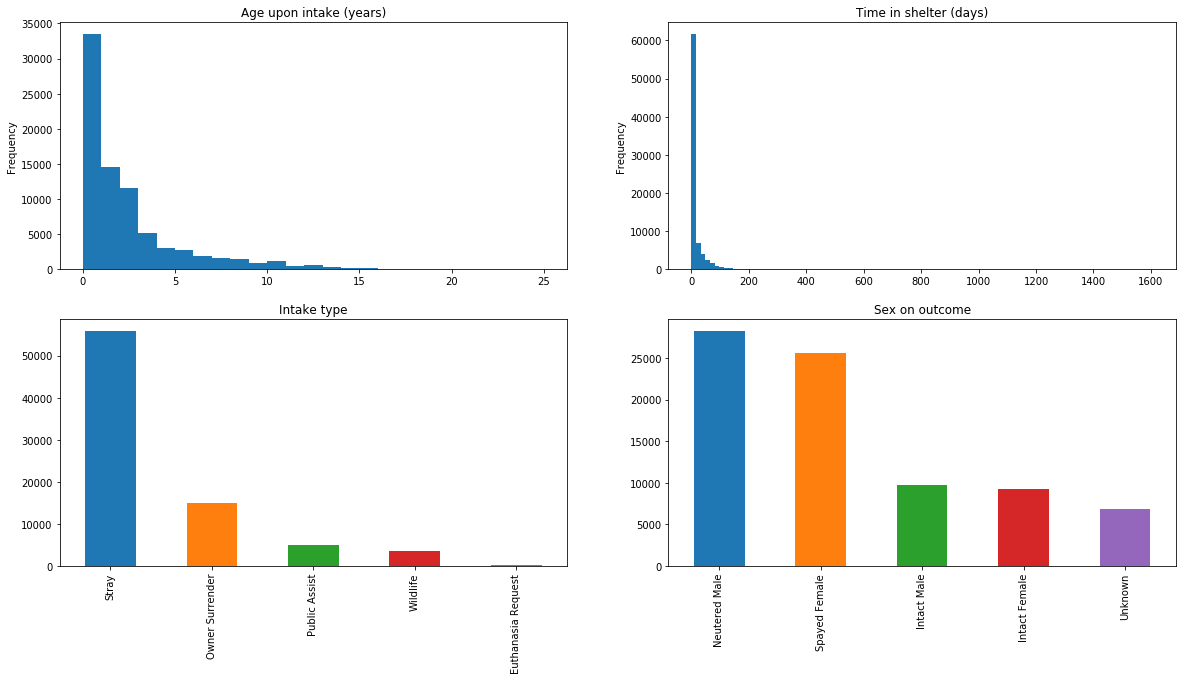

In [61]:
fig, axs = plt.subplots(2, 2)
X_categorical['age_upon_intake_(years)'].plot(kind='hist', bins=25,ax=axs[0][0], figsize=(20, 10), title='Age upon intake (years)')
X_categorical['time_in_shelter_days'].plot(kind='hist', bins=100, ax=axs[0][1], title = 'Time in shelter (days)')
X_categorical['intake_type'].value_counts().plot(kind='bar', ax=axs[1][0], title='Intake type')
X_categorical['sex_upon_outcome'].value_counts().plot(kind='bar', ax=axs[1][1], title='Sex on outcome')

__Impact of the features__

There seems to be 4 basic categories that matter to whether an animal will be adopted or not:

1) The age of the animal: People prefer young ones

2) The time spent in the shelter: ?

3) The intake type: Owner surrender

5) The sex and reproductive status on outcome:

__D) Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.__

In [68]:
#Fine-tuning the parameters
#n_estimators = nb trees in forest

#test each pair (#trees, max-depth) in a given range of #trees and depths (grid search)
stats = []
matrices = []
for n in range(90, 100):
    for depth in range(10, 15):
        forest = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=0)
        stat = k_fold_cross_validate(train_X_std, train_y, 5, thresh, forest)
        
        #add #trees and depth to stats
        stat[0] = n
        stat.append(depth)
        stats.append(stat)
        matrices.append(matrix)
        
performances = pd.DataFrame(stats, columns=['n_estimators', 'Accuracy','+Precision', 
                                            '-Precision', '+Recall', '-Recall', 
                                            '+F1', '-F1', 'max_depth'])


In [69]:
performances

,n_estimators,Accuracy,+Precision,-Precision,+Recall,-Recall,+F1,-F1,max_depth
0,93,0.852511,0.886627,0.809793,0.853887,0.850579,0.869934,0.829664,12
1,93,0.852956,0.887827,0.809412,0.853282,0.852525,0.870206,0.830400,13
2,94,0.852067,0.886637,0.808821,0.852990,0.850816,0.869479,0.829272,12
3,94,0.853339,0.887842,0.810186,0.854047,0.852365,0.870614,0.830736,13
4,95,0.852849,0.888606,0.808445,0.852137,0.853890,0.869974,0.830519,12
5,95,0.853938,0.889077,0.810122,0.853657,0.854425,0.870992,0.831654,13
6,96,0.852021,0.885489,0.809879,0.854350,0.848884,0.869631,0.828905,12
7,96,0.853217,0.889362,0.808469,0.851919,0.855076,0.870214,0.831079,13
8,97,0.852542,0.886749,0.809683,0.853810,0.850831,0.869956,0.829728,12
9,97,0.853079,0.888371,0.809210,0.852915,0.853308,0.870260,0.830641,13


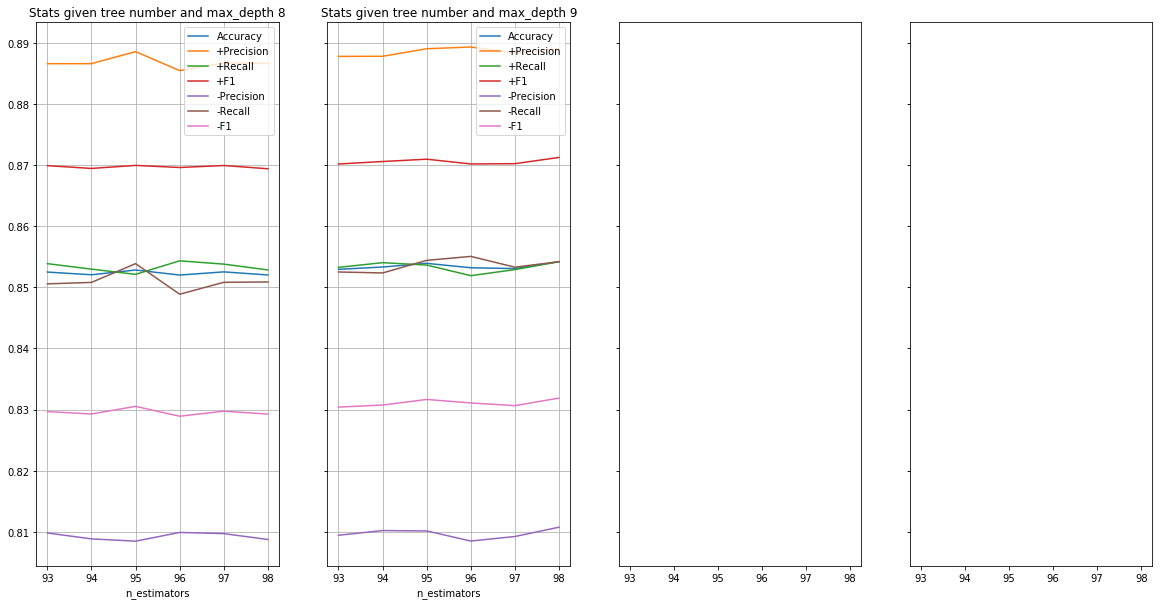

In [71]:
#plot the data
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True)
performances[performances['max_depth'] == 10]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[0], grid=True, title='Stats given tree number and max_depth 8', figsize=(20, 10))

performances[performances['max_depth'] == 11]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[1], grid=True, title='Stats given tree number and max_depth 9', figsize=(20, 10))

performances[performances['max_depth'] == 12]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[2], grid=True, title='Stats given tree number and max_depth 10', figsize=(20, 10))

performances[performances['max_depth'] == 13]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[3], grid=True, title='Stats given tree number and max_depth 11', figsize=(20, 10))

performances[performances['max_depth'] == 14]\
    .plot(kind='line', x='n_estimators', y=['Accuracy', '+Precision', '+Recall', '+F1','-Precision', '-Recall', '-F1'], 
        ax=axs[3], grid=True, title='Stats given tree number and max_depth 11', figsize=(20, 10))

* Best number of trees: 94

* Best max depth: 12? (Avoid overfitting)

In [66]:
#train and compare with threshold 0.56

thresh = 0.56

print('--------------------------Random Forest Classifier-------------------------------')
start_time_forest = time.time()
forest = RandomForestClassifier(n_estimators=94, max_depth=12, random_state=0)
forest.fit(train_X_std, train_y)
prediction_probs_forest = pd.DataFrame(forest.predict_proba(test_X_std))
pred_forest = prediction_probs_forest[1].map(lambda r: threshold(r, thresh))

matrix = confusion_matrix(test_y, pred_forest)
get_performance_eval(matrix, 0.56, True, True)
print('Elapsed time for random forests: ', time.time() - start_time_forest)
print('\n')
print('-------------------------Logistic Regression (as seen above)---------------------')

#Evaluation of prediction with threshold=0.56
start_time_log = time.time()
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(train_X_std, train_y)
prediction_probs_logistic = pd.DataFrame(logistic.predict_proba(test_X_std))
pred_log = prediction_probs_logistic[1].map(lambda r: threshold(r, thresh))
matrix = confusion_matrix(test_y, pred_log)
get_performance_eval(matrix, 0.56, True, True)
print('Elapsed time for logistic regression: ', time.time() - start_time_log)

--------------------------Random Forest Classifier-------------------------------
Stats--------------------------------------------------
 
Threshold:  0.56
 
Matrix: 
[[7940 1314]
 [1186 5494]]

Accuracy:   0.843102799046065
 
              Positive         / Negative
Precision:  0.8700416392724085 / 0.8069917743830788
Recall:     0.8580073481737627 / 0.8224550898203593
F1-Score:   0.8639825897714907 / 0.814650059311981
-------------------------------------------------------
Elapsed time for random forests:  2.8279099464416504


-------------------------Logistic Regression (as seen above)---------------------
Stats--------------------------------------------------
 
Threshold:  0.56
 
Matrix: 
[[7760 1494]
 [1447 5233]]

Accuracy:   0.8154261327977909
 
              Positive         / Negative
Precision:  0.8428369718692299 / 0.7779099152668352
Recall:     0.8385562999783878 / 0.7833832335329342
F1-Score:   0.8406911868262825 / 0.7806369806817334
-------------------------------------

We see that the forest is slightly more precise, but takes more time.

This makes sense because a random forest classifer needs to build trees, which takes more time than simple logistic regression. 